Here I provide a step-by-step example of: constructing count-weighted datasets, aligning them, traning models, visualize sequence motifs and perform dimensionality reduction

In [1]:
rootf = FOLDER ## place here the folder where you save PGM, Align_utils and the other files inside rbm_tcell, for example /user/rbm_tcell ##

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

curr_float = np.float32
curr_int = np.int16

def convert_number(seqs): # convert to numbers already aligned seqs
    aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V',  'W', 'Y','-']
    aadict = {aa[k]: k for k in range(len(aa))}
    msa_num = np.array(list(map(lambda x: [aadict[y] for y in x], seqs[0:])), dtype=curr_int, order="c")
    
    return msa_num

def convert_letter(seqs_n): # convert to numbers already aligned seqs
    aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V',  'W', 'Y','-']
    aadictinv = {k: aa[k] for k in range(len(aa))} 
    seqs=[]
    if type(seqs_n[0]) == curr_int:
        seqs.append(''.join([aadictinv[e] for e in seqs_n]))
    else:
        for t in range(len(seqs_n)):
            seqs.append(''.join([aadictinv[e] for e in seqs_n[t]]))
    return seqs

def flatten_list(listoflist):
    listoflist_fl = [];
    for l in range(len(listoflist)):
        for u in range(len(listoflist[l])):
            listoflist_fl.append(listoflist[l][u])
    return listoflist_fl

def ll_seq_pp(data_seqs_val_3w_n,name_sample,hu,l12,remback):
    path_in = rootf  + '/Example'
    name_post = '/' + name_sample + '_model_' + str(hu) + '_' + str(l12) + '_post.data'
    RBM = RBM_utils.loadRBM(path_in + name_post)
    
    if remback==1:
        name_pre = '/' + name_sample + '_model_' + str(hu) + '_' + str(l12) + '_pre.data'
        RBM_d0 = RBM_utils.loadRBM(path_in + name_pre)
        ll =  RBM.likelihood(data_seqs_val_3w_n) - RBM_d0.likelihood(data_seqs_val_3w_n)
    else:
        ll = RBM.likelihood(data_seqs_val_3w_n)
		
    return ll

#%matplotlib inline
import sys, os, pickle

sys.path.append(rootf + '/PGM/source/')
sys.path.append(rootf + '/PGM/utilities/')
sys.path.append(rootf + '/Align_utils/')
from common_imports import set_num_threads
set_num_threads(1) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm,utilities
import Proteins_utils, RBM_utils, utilities, sequence_logo, plots_utils

import subprocess
import numpy.matlib 
import random
from sklearn import metrics

# Plots stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import patches
from pandas.plotting import table
mpl.rcParams['font.family'] = ['Garuda']
mpl.rcParams['font.serif'] = ['Garuda-Oblique']

/usr/local/lib/python3.9/dist-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/home/barbara/rbm_tcell/PGM/source/numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
/home/barbara/rbm_tcell/PGM/source/numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


These blocks are to align sequences and produce count-weighted datasets

In [ ]:
## Take all the samples to analyze, align the sequences, write in the tables the aligned version of sequences ##

samples = ['example_file','example_file2'] ## Here one needs to specify the list of repertoires to compare
all_seqs = []
for ss in samples:
    table_data = pd.read_csv(rootf + '/Example/' + ss + '.tsv', sep='\t', low_memory=False)     
    seqs = list(table_data['CDR3'])
    all_seqs.append(seqs)
all_seqs=flatten_list(all_seqs)

## This block is to align the sequences ##
name_mat = rootf + '/Align_utils/align_protpy.py'

SA = 19
SAmin = 5
SAmax = 23

all_seqs1 = list(np.unique(all_seqs))

name_seed = rootf + '/Align_utils/prots_seed.txt'
with open(name_seed, 'w') as out_f:
    for u in range(len(all_seqs1)):
        if len(all_seqs1[u]) >= 5:  
            out_f.write(all_seqs1[u] + '\n')

subprocess.call('python3 ' + name_mat + ' -ss ' + name_seed + ' -SA ' + str(SA) + ' -SAmin ' + str(SAmin) + ' -SAmax ' + str(SAmax) + ' -rootf ' + str(rootf), shell = True)

seqs_al = np.loadtxt(rootf + '/Align_utils/aligned_prot.txt')
sn = seqs_al.astype(np.int)
seqs_al = convert_letter(sn) ## this is the aligned dataset ##

## add in the files a column with the aligned sequences ##
for sam in samples:
    
    table_data = pd.read_csv(rootf + '/Example/' + sam + '.tsv', sep='\t', low_memory=False)     
    seqs = list(table_data['CDR3'])
    list_aligned =[]
    for s in seqs:
        ind = all_seqs1.index(s)
        list_aligned.append(seqs_al[ind])
        
    table_data['CDR3_gap'] = list_aligned
    table_data.to_csv(rootf + '/Example/' + sam + '_aligned.tsv', sep='\t')

In [4]:
## Let us focus on the first sample: read tables with counts before and after antigen stimulation ##

name_pos = 'Count post-stimulation'
name_neg = 'Count pre-stimulation'

file_name = 'example_file' ## Choose the file with the sample ##
table_data = pd.read_csv(rootf + '/Example/' + file_name + '_aligned.tsv', sep='\t', low_memory=False)     
seqs = list(table_data['CDR3'])
seqs_al = list(table_data['CDR3_gap'])
mult_seqs_post = table_data[name_pos].values
mult_seqs_pre = table_data[name_neg].values

path_in = rootf  + '/Example' ## simply the folder where the CDR3 sample is saved - note it is a count-weighted dataset of aligned sequences  

In [ ]:
## produce count-weighted datasets, i.e. datasets where each sequence is present as many times as its count pre or post stimulation ##

seqs_post_training = []
for u in range(len(seqs_al)):
    repl = np.matlib.repmat(seqs_al[u], mult_seqs_post[u], 1).tolist()
    for y in repl:
        seqs_post_training.append(y[0]) 
        
seqs_pre_training = []
for u in range(len(seqs_al)):
    repl = np.matlib.repmat(seqs_al[u], mult_seqs_pre[u], 1).tolist()
    for y in repl:
        seqs_pre_training.append(y[0]) 

random.shuffle(seqs_post_training)
random.shuffle(seqs_pre_training)

filename = path_in + '/' + file_name + '_post.fasta'
sequences = seqs_post_training

all_labels = ['S%s'%k for k in range(len(sequences))]
with open(filename,'w') as fil:
    for seq, label in zip(sequences,all_labels):
        fil.write('>%s\n'%label)
        fil.write('%s\n'%seq)
        
filename = path_in + '/' + file_name + '_pre.fasta'
sequences = seqs_pre_training

all_labels = ['S%s'%k for k in range(len(sequences))]
with open(filename,'w') as fil:
    for seq, label in zip(sequences,all_labels):
        fil.write('>%s\n'%label)
        fil.write('%s\n'%seq)

These blocks are to train the RBM models, to visualize their parameters and low-dimensional data representation to extract features characterizing response 

In [2]:
## Here I select load the sample in FASTA format I have just produced ##
file_name = 'example_file' 
path_in = rootf  + '/Example'
TS=80 ## percentage of the dataset to learn the model ##

# Load Data
filename_post = '/' + file_name + '_post.fasta'
all_data_post = Proteins_utils.load_FASTA(path_in + filename_post,with_labels=False,remove_insertions=False, drop_duplicates=False)

filename_pre = '/' + file_name + '_pre.fasta'
all_data_pre = Proteins_utils.load_FASTA(path_in + filename_pre,with_labels=False,remove_insertions=False, drop_duplicates=False)

## From here, I learn RBM and next manipulate the outcome ##
n_v = 19 # Number of visible units; = # sites in alignment.
n_h = 25 # Number of hidden units - hyperparameter chosen as explained in Fig. S4
l12 = 0.1 # Regularization - hyperparameter chosen as explained in Fig. S4

# Decide the name for the output #
namem_pre = '/' + file_name + '_model_' + str(n_h) + '_' + str(l12) + '_pre.data'
namem_post = '/' + file_name + '_model_' + str(n_h) + '_' + str(l12) + '_post.data'

## RBM training ##
maketraining = 0 # Variable to decide whether you want to train a new model or to load an existing one 

if maketraining:
    
    ## These are parameters for the training ##
    visible = 'Potts' # Nature of visible units potential. Here, Potts states for amino acids
    n_cv = 21 # With n_cv = 21 colors (all possible amino acids + gap)
    hidden = 'dReLU' # Nature of hidden units potential. Here, dReLU potential.
    seed = 0 # Random seed (optional)
    batch_size = 100 # Size of mini-batches (and number of Markov chains used). Default: 100.
    n_iter = 200 # Number of epochs
    learning_rate = 0.1 # Initial learning rate (default: 0.1)
    decay_after = 0.5 # Decay learning rate after 50% of iterations (default: 0.5)	
    N_MC = 10 # Number of Monte Carlo steps between each update
    l1b=l12
    
    B = all_data_post.shape[0]
    RBM_post = rbm.RBM(visible = visible,hidden = hidden ,n_v = n_v,n_h = n_h, n_cv = n_cv, random_state = seed, zero_field = False)
    l2f = 1/len(all_data_post[0:int(B/100*TS)])
    RBM_post.fit(all_data_post[0:int(B/100*TS)], weights=None, batch_size = batch_size,n_iter = n_iter, l1b = l1b, l2_fields = l2f, N_MC = N_MC, decay_after = decay_after, verbose = 1)
    RBM_utils.saveRBM(path_in + namem_post, RBM_post)
    
    B = all_data_pre.shape[0]
    RBM_pre = rbm.RBM(visible = visible,hidden = hidden,n_v = n_v,n_h = n_h, n_cv = n_cv, random_state = seed, zero_field = False)
    l2f = 1/len(all_data_pre[0:int(B/100*TS)])
    RBM_pre.fit(all_data_pre[0:int(B/100*TS)], weights=None, batch_size = batch_size,n_iter = n_iter, l1b = l1b, l2_fields = l2f, N_MC = N_MC, decay_after = decay_after, verbose = 1)
    RBM_utils.saveRBM(path_in + namem_pre, RBM_pre)
else:
    RBM_pre = RBM_utils.loadRBM(path_in + namem_pre)
    RBM_post = RBM_utils.loadRBM(path_in + namem_post)

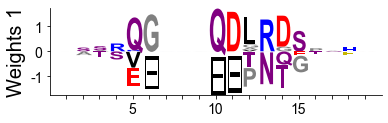

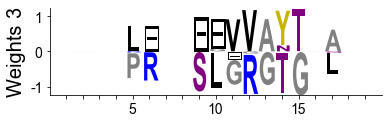

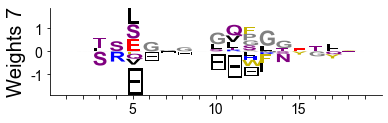

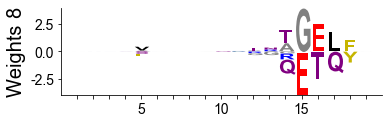

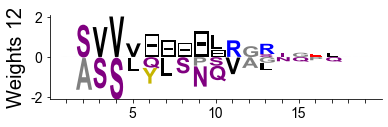

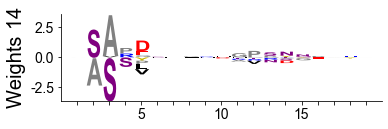

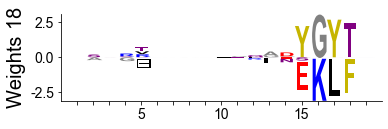

In [4]:
## Model's parameters inspection ##

weights = RBM_post.weights ## Interesting features are the ones picked up in the 3 weeks sample ##

s2=16;
interesting_features = [0,2,6,7,11,13,17] ## select what hidden units inspect 
for i in range(len(interesting_features)):
    fig = sequence_logo.Sequence_logo(weights[interesting_features[i]], figsize=(5.5,1.8), ylabel = 'Weights ' + str(interesting_features[i]+1),  ticks_every=5, ticks_labels_size=s2-2) 

Mismatch dimensions (100, 25), [10, 25], reinitializating I
Mismatch dimensions (100, 19, 21), [10, 19, 21], reinitializating I


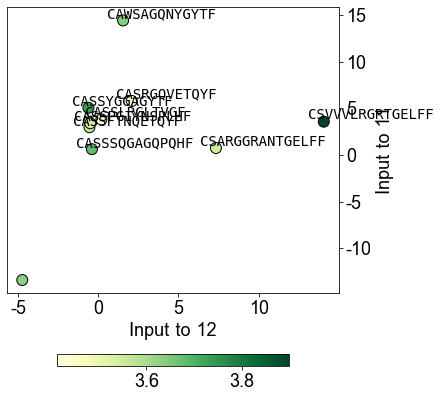

In [6]:
## Evaluate the model likelihood ##
seqs_n = convert_number(seqs_al)
ll_post = RBM_post.likelihood(seqs_n)

## Projection onto the RBM representation space##

ind_sort = np.argsort(ll_post)[::-1]
ntop = 10 ## how many sequences to plot##

I = RBM_post.vlayer.compute_output(seqs_n[ind_sort[:ntop]],RBM_post.weights)

ix = 11
iy = 10

s1 = 120.0
fig, ax = plt.subplots()
fig.set_figwidth(6.2)
fig.set_figheight(6)

listan = [seqs[ind_sort[t]] for t in range(ntop)]
x=I[:,ix]
y=I[:,iy]

sc = ax.scatter(x,y, s=s1, c = np.log10(mult_seqs_post[ind_sort[:ntop]]), edgecolors='k', cmap='YlGn')
for i, txt in enumerate(listan):
    ax.annotate(txt, (x[i]-1, y[i]+0.25), fontfamily='monospace', fontvariant='small-caps', fontsize=14)

s2=18
ax.set_xlabel('Input to ' + str(ix+1), fontsize=s2)
ax.set_ylabel('Input to ' + str(iy+1), fontsize=s2)

cbar = plt.colorbar(mappable=sc, ax=ax, shrink=0.7,orientation='horizontal')
cbar.ax.tick_params(labelsize=s2)

ax.tick_params(axis='both', which='major', labelsize = s2)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.tight_layout()

In [15]:
## Print top likelihood sequences ##
all_seqs1 = list(np.array(seqs)[ind_sort[:100]])
name_f = path_in + '/' + file_name + '_post_top100.txt'
with open(name_f, 'w') as out_f:
    for u in range(len(all_seqs1)):
        out_f.write(all_seqs1[u] + '\n')

Here I estimate the response score (both using the replicate at day 0 or, if it is not available, the model for a normal, unstimulated repertoire) and I check that they well reproduce the degree of fold change.

In [15]:
ll_post = RBM_post.likelihood(seqs_n)
ll_pre = RBM_pre.likelihood(seqs_n)

## If pre-stimulation data are not available, here I upload models for a normal, unstimulated repertoire ##
RBM_pre_pgen = RBM_utils.loadRBM(rootf + '/Models/CDR3out_Pgen/model_25_0.1.data') ## model for a generated repertoire (which has not undergone thymic selection)
RBM_pre_ppost = RBM_utils.loadRBM(rootf + '/Models/CDR3out_Ppost/model_25_0.1.data') ## model for a naive repertoire (which has undergone thymic selection)
ll_pre_pgen = RBM_pre_pgen.likelihood(seqs_n)
ll_pre_ppost = RBM_pre_ppost.likelihood(seqs_n)

## Definition of response scores ##
response_score = ll_post - ll_pre
response_score_pgen = ll_post - ll_pre_pgen
response_score_ppost = ll_post - ll_pre_ppost

log_fold_change = np.log10(mult_seqs_post+1/2) - np.log10(mult_seqs_pre+1/2)

Mismatch dimensions (100, 25), [10, 25], reinitializating I
Mismatch dimensions (100, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (100, 25), [10, 25], reinitializating I
Mismatch dimensions (100, 19, 21), [10, 19, 21], reinitializating I


In [18]:
ind_sortm = np.argsort(mult_seqs_post)[::-1] 

## The likelihood is correlated to the counts ##
print('Correlation to count - likelihood of 100 most abundant clones')
print(np.corrcoef(ll_post[ind_sortm[:100]], np.log10(mult_seqs_post[ind_sortm[:100]]+1/2))[0,1])

## Here I show the correlation of the response score to the fold change ##
print('Correlation to fold change - response score of 100 most abundant clones')
print(np.corrcoef(response_score[ind_sortm[:100]], log_fold_change[ind_sortm[:100]])[0,1])

print('Correlation to fold change - response score (pgen) of 100 most abundant clones')
print(np.corrcoef(response_score_pgen[ind_sortm[:100]], np.log10(mult_seqs_post[ind_sortm[:100]]+1/2))[0,1])

print('Correlation to fold change - response score (ppost) of 100 most abundant clones')
print(np.corrcoef(response_score_ppost[ind_sortm[:100]], np.log10(mult_seqs_post[ind_sortm[:100]]+1/2))[0,1])

Correlation to count - likelihood of 100 most abundant clones
0.8131705526433155
Correlation to fold change - response score of 100 most abundant clones
0.6753057081580327
Correlation to fold change - response score (pgen) of 100 most abundant clones
0.7575392246129382
Correlation to fold change - response score (ppost) of 100 most abundant clones
0.715134311696421


I consider a second sample and I compare the two samples through the models' score to 
obtain the AUROC of specificity

In [5]:
## Repeat the model training for the second sample ##
maketraining = 0
file_name = 'example_file2'
table_data = pd.read_csv(rootf + '/Example/' + file_name + '_aligned.tsv', sep='\t', low_memory=False)  

## Same portion of code to train models for the second sample ##
seqs = list(table_data['CDR3'])
seqs_al = list(table_data['CDR3_gap'])
mult_seqs_post = table_data[name_pos].values
mult_seqs_pre = table_data[name_neg].values

path_in = rootf  + '/Example' ## simply the folder where the CDR3 sample is saved - note it is a count-weighted dataset of aligned sequences  

seqs_post_training = []
for u in range(len(seqs_al)):
    repl = np.matlib.repmat(seqs_al[u], mult_seqs_post[u], 1).tolist()
    for y in repl:
        seqs_post_training.append(y[0]) 
        
seqs_pre_training = []
for u in range(len(seqs_al)):
    repl = np.matlib.repmat(seqs_al[u], mult_seqs_pre[u], 1).tolist()
    for y in repl:
        seqs_pre_training.append(y[0]) 

random.shuffle(seqs_post_training)
random.shuffle(seqs_pre_training)

filename = path_in + '/' + file_name + '_post.fasta'
sequences = seqs_post_training

all_labels = ['S%s'%k for k in range(len(sequences))]
with open(filename,'w') as fil:
    for seq, label in zip(sequences,all_labels):
        fil.write('>%s\n'%label)
        fil.write('%s\n'%seq)
        
filename = path_in + '/' + file_name + '_pre.fasta'
sequences = seqs_pre_training

all_labels = ['S%s'%k for k in range(len(sequences))]
with open(filename,'w') as fil:
    for seq, label in zip(sequences,all_labels):
        fil.write('>%s\n'%label)
        fil.write('%s\n'%seq)

TS=80 ## percentage of the dataset to learn the model ##

# Load Data
filename_post = '/' + file_name + '_post.fasta'
all_data_post = Proteins_utils.load_FASTA(path_in + filename_post,with_labels=False,remove_insertions=False, drop_duplicates=False)

filename_pre = '/' + file_name + '_pre.fasta'
all_data_pre = Proteins_utils.load_FASTA(path_in + filename_pre,with_labels=False,remove_insertions=False, drop_duplicates=False)

n_v = 19 # Number of visible units; = # sites in alignment.
n_h = 25 # Number of hidden units - hyperparameter chosen as explained in Fig. S4
l12 = 0.1 # Regularization - hyperparameter chosen as explained in Fig. S4

namem_pre = '/' + file_name + '_model_' + str(n_h) + '_' + str(l12) + '_pre.data'
namem_post = '/' + file_name + '_model_' + str(n_h) + '_' + str(l12) + '_post.data'

if maketraining:
    
    visible = 'Potts' # Nature of visible units potential. Here, Potts states for amino acids
    n_cv = 21 # With n_cv = 21 colors (all possible amino acids + gap)
    hidden = 'dReLU' # Nature of hidden units potential. Here, dReLU potential.
    seed = 0 # Random seed (optional)
    batch_size = 100 # Size of mini-batches (and number of Markov chains used). Default: 100.
    n_iter = 200 # Number of epochs
    learning_rate = 0.1 # Initial learning rate (default: 0.1)
    decay_after = 0.5 # Decay learning rate after 50% of iterations (default: 0.5)	
    N_MC = 10 # Number of Monte Carlo steps between each update
    l1b=l12
    
    B = all_data_post.shape[0]
    RBM_post = rbm.RBM(visible = visible,hidden = hidden ,n_v = n_v,n_h = n_h, n_cv = n_cv, random_state = seed, zero_field = False)
    l2f = 1/len(all_data_post[0:int(B/100*TS)])
    RBM_post.fit(all_data_post[0:int(B/100*TS)], weights=None, batch_size = batch_size,n_iter = n_iter, l1b = l1b, l2_fields = l2f, N_MC = N_MC, decay_after = decay_after, verbose = 1)
    RBM_utils.saveRBM(path_in + namem_post, RBM_post)
    
    B = all_data_pre.shape[0]
    RBM_pre = rbm.RBM(visible = visible,hidden = hidden,n_v = n_v,n_h = n_h, n_cv = n_cv, random_state = seed, zero_field = False)
    l2f = 1/len(all_data_pre[0:int(B/100*TS)])
    RBM_pre.fit(all_data_pre[0:int(B/100*TS)], weights=None, batch_size = batch_size,n_iter = n_iter, l1b = l1b, l2_fields = l2f, N_MC = N_MC, decay_after = decay_after, verbose = 1)
    RBM_utils.saveRBM(path_in + namem_pre, RBM_pre)
else:
    RBM_pre = RBM_utils.loadRBM(path_in + namem_pre)
    RBM_post = RBM_utils.loadRBM(path_in + namem_post)

In [6]:
## Find the AUROC of specificity ##

samples = ['example_file','example_file2'] ## Here one needs to specify the list of repertoires to compare
MP = len(samples)
remback = 0 ## choose 1 only if the pre-stimulation 

## parameters of RBM model ##
hu=25
l12=0.1
## construct the dataset over which the specificity score should be evaluated - here I merge the validation sets post-stimulation ##

validation_set = []
for i in range(MP):
    filename_post = '/' + samples[i] + '_post.fasta'
    alignresh = Proteins_utils.load_FASTA(path_in + filename_post, with_labels=False, remove_insertions=False, drop_duplicates=False)
    B=len(alignresh)
    validation_set.append(convert_letter(alignresh[int(B/100*TS):])) 
validation_set=flatten_list(validation_set)

data_seqs_val_3w = validation_set
data_seqs_val_3w_n = convert_number(data_seqs_val_3w)  

listll=[]
listfc=[]
for r in range(MP):

    ll = ll_seq_pp(data_seqs_val_3w_n,samples[r],hu,l12,remback)
    fc = np.zeros(len(data_seqs_val_3w_n)) 
    ps = 0.5 ## pseudo-count to avoid ill-defined counts
        
    summary = pd.read_csv(rootf + '/Example/' + samples[r] + '_aligned.tsv', sep='\t', low_memory=False) 
    multpost = (summary[name_pos].values)
    seqs_g = list(summary['CDR3_gap'].values.astype(np.str))
    for s0 in range(len(data_seqs_val_3w)):
        s=data_seqs_val_3w[s0]
        if s in seqs_g:
            ind = seqs_g.index(s)
            if remback:
                multpre = (summary[name_neg].values)
                fc[s0] = np.log10((multpost[ind]+ps)/(multpre[ind]+ps))
            else:
                fc[s0] = np.log10(multpost[ind]+ps)

    listll.append(ll)
    listfc.append(fc)
    
ztot=zip(data_seqs_val_3w, *listll)

nr = rootf + '/Example/Specificity_tables/auroc.txt'
with open(nr, 'w') as out_f:
    title= 'CDR3' + '\t'
    for r in range(MP):
        pep = samples[r]
        title = title + pep + '\t'
    out_f.write(title + '\n')
    writer = csv.writer(out_f, delimiter='\t')
    writer.writerows(ztot)

ztot=zip(data_seqs_val_3w, *listfc)

nr = rootf + '/Example/Specificity_tables/log10fc.txt'
with open(nr, 'w') as out_f:
    title= 'CDR3' + '\t'
    for r in range(MP):
        pep = samples[r]
        title = title + pep + '\t'
    out_f.write(title + '\n')
    writer = csv.writer(out_f, delimiter='\t')
    writer.writerows(ztot)
    
## rank all sequences under all models ##
beginl=1 

for r in range(MP):
    seq2fc=[]
    seqfc=[]
    with open(rootf + '/Example/Specificity_tables/log10fc.txt') as f: 
        for line in f:
            linesplit = line.strip().split('\t')
            nogap2=linesplit[0].replace(' ','')
            seq2fc.append(nogap2)
            seqfc.append(linesplit[beginl:len(linesplit)])
    PL=np.zeros(len(seq2fc)-1)
    for l in range(1,len(seq2fc)):
        listot=[]
        listdiff=[]
        for i in range(r):
            listot.append(float(seqfc[l][i]))
            listdiff.append(abs(float(seqfc[l][r])-float(seqfc[l][i])))
        for i in range(r+1,len(seqfc[l])):
            listot.append(float(seqfc[l][i]))
            listdiff.append(abs(float(seqfc[l][r])-float(seqfc[l][i])))
        if np.argmax(seqfc[l]) == r:
            PL[l-1]=1
    labels_fc=np.copy(PL)

    seq2=[]
    seqll=[]
    with open(rootf + '/Example/Specificity_tables/auroc.txt') as f: 
        for line in f:
            linesplit = line.strip().split('\t')
            nogap2=linesplit[0].replace(' ','')
            seq2.append(nogap2)
            seqll.append(linesplit[beginl:len(linesplit)])
    PLL=np.zeros(len(seq2)-1)
    for l in range(1,len(seq2)):
        listot=[]
        listdiff=[]
        for i in range(r):
            listot.append(float(seqll[l][i]))
            listdiff.append(abs(float(seqll[l][r])-float(seqll[l][i])))
        for i in range(r+1,len(seqll[l])):
            listot.append(float(seqll[l][i]))
            listdiff.append(abs(float(seqll[l][r])-float(seqll[l][i])))
        score = float(seqll[l][r]) - listot[np.argmin(listdiff)]
        PLL[l-1] = score
    scores = np.copy(PLL) 

    fpr, tpr, thresholds = metrics.roc_curve(labels_fc, scores)
    auroc = metrics.auc(fpr, tpr)
    print(auroc)

Mismatch dimensions (100, 25), [10, 25], reinitializating I
Mismatch dimensions (100, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (100, 25), [10, 25], reinitializating I
Mismatch dimensions (100, 19, 21), [10, 19, 21], reinitializating I
0.9023169143339815
0.9023169143339815


Here I show the training of the left-right version along with the sequence encoding needed

In [7]:
def encode_LR(seq_train,max_L):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY' ## alphabet of symbols ##
    aadict = {amino_acids[k]: k for k in range(len(amino_acids))} 
    max_depth = max_L

    features = []
    for aa in amino_acids:
        features += [['a' + aa + str(L)] for L in range(max_depth)]
        features += [['a' + aa + str(L)] for L in range(-max_depth, 0)] # features for encoding

    features_r = []
    for aa in amino_acids:
        features_r += [['a\t' + aa + '\t' + str(L)] for L in range(max_depth)]
        features_r += [['a\t' + aa + '\t' + str(L)] for L in range(-max_depth, 0)]  # features for writing

    feature_dict = {tuple(f): i for i, f in enumerate(features)}
    feature_dict_inv = {i:f for i, f in enumerate(features)}

    seq_train_LR=[]
    for t in range(len(seq_train)):
        seq = seq_train[t]
        seq_feature_lsts = [['a' + aa + str(i)] for i, aa in enumerate(seq)]
        seq_feature_lsts += [['a' + aa + str(-1-i)] for i, aa in enumerate(seq[::-1])]
        seq_features = list(set([feature_dict[tuple(f)] for f in seq_feature_lsts if tuple(f) in feature_dict]))
        length_input=len(features)
        data=np.array(seq_features)
        data_enc = np.zeros(length_input, dtype=np.int8)
        for i in range(len(data)): data_enc[data[i]] = 1
        seq_train_LR.append(list(data_enc))
    seq_train_LR = np.array(seq_train_LR)

    return seq_train_LR

def weights_LR(RBM,max_L):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY' ## alphabet of symbols ##
    aadict = {amino_acids[k]: k for k in range(len(amino_acids))} 
    max_depth = max_L

    features = []
    for aa in amino_acids:
        features += [['a' + aa + str(L)] for L in range(max_depth)]
        features += [['a' + aa + str(L)] for L in range(-max_depth, 0)] # features for encoding

    features_r = []
    for aa in amino_acids:
        features_r += [['a\t' + aa + '\t' + str(L)] for L in range(max_depth)]
        features_r += [['a\t' + aa + '\t' + str(L)] for L in range(-max_depth, 0)]  # features for writing
        
    # re-size matrices
    Na=len(amino_acids)
    W_fin_L = np.zeros((hu,max_L,len(amino_acids)))
    W_fin_R = np.zeros((hu,max_L,len(amino_acids)))
    
    for u in range(len(features_r)):
        string = features_r[u][0]
        split_string = string.split("\t")
        if split_string[0] == 'a':
            ind_aa = aadict[split_string[1]]
            ind_pos = int(split_string[2])
            if ind_pos >= 0:
                W_fin_L[:,ind_pos,ind_aa] = (RBM.weights)[:,u,1]  #
            if ind_pos < 0:
                W_fin_R[:,ind_pos,ind_aa] = (RBM.weights)[:,u,1]
            
    ## enforce a zero-sum gauge for visualization ##
    Wzs_fin_L = np.zeros((hu,max_L,len(amino_acids)))
    Wzs_fin_R = np.zeros((hu,max_L,len(amino_acids)))
    for m in range(hu):
        for i in range(max_L):
            Wzs_fin_L[m,i,:] = W_fin_L[m,i,:] - 1/(Na)*np.sum(W_fin_L[m,i,:])
            Wzs_fin_R[m,i,:] = W_fin_R[m,i,:] - 1/(Na)*np.sum(W_fin_R[m,i,:])


    return (Wzs_fin_L, Wzs_fin_R)

In [46]:
file_name = 'example_file'
table_data = pd.read_csv(rootf + '/Example/' + file_name + '_aligned.tsv', sep='\t', low_memory=False)  
seqs = list(table_data['CDR3'])
seqs_al = list(table_data['CDR3_gap'])

filename_post = '/' + file_name + '_post.fasta'
all_data_postA = Proteins_utils.load_FASTA(path_in + filename_post,with_labels=False,remove_insertions=False, drop_duplicates=False)
filename_pre = '/' + file_name + '_pre.fasta'
all_data_preA = Proteins_utils.load_FASTA(path_in + filename_pre,with_labels=False,remove_insertions=False, drop_duplicates=False)
all_data_postAl = convert_letter(all_data_postA)
all_data_preAl = convert_letter(all_data_preA)

all_data_preT = []
for ll in all_data_preAl:
    ii = seqs_al.index(ll)
    all_data_preT.append(seqs[ii])
    
all_data_postT = []
for ll in all_data_postAl:
    ii = seqs_al.index(ll)
    all_data_postT.append(seqs[ii])
    
max_L = 19 ## Reference length for the encoding - 19 is quite high, lower one (~10) is still fine
## Here I simply change the data encoding ##
all_data_pre = encode_LR(all_data_preT,max_L)
all_data_post = encode_LR(all_data_postT,max_L)

## From here, I learn RBM and next manipulate the outcome ##
n_h = 25 # Number of hidden units - hyperparameter chosen as explained in Fig. S4
l12 = 0.1 # Regularization - hyperparameter chosen as explained in Fig. S4
n_v = len(all_data_pre[0])

# Decide the name for the output #
namem_pre = '/' + file_name + '_model_' + str(n_h) + '_' + str(l12) + '_pre_LR.data'
namem_post = '/' + file_name + '_model_' + str(n_h) + '_' + str(l12) + '_post_LR.data'

## RBM_LR training ##
maketraining = 0 # Variable to decide whether you want to train a new model or to load an existing one 

if maketraining:
    
    ## These are parameters for the training ##
    visible = 'Potts' # Nature of visible units potential. Here, Potts states for amino acids
    n_cv = 21 # With n_cv = 21 colors (all possible amino acids + gap)
    hidden = 'dReLU' # Nature of hidden units potential. Here, dReLU potential.
    seed = 0 # Random seed (optional)
    batch_size = 100 # Size of mini-batches (and number of Markov chains used). Default: 100.
    n_iter = 200 # Number of epochs
    learning_rate = 0.1 # Initial learning rate (default: 0.1)
    decay_after = 0.5 # Decay learning rate after 50% of iterations (default: 0.5)	
    N_MC = 10 # Number of Monte Carlo steps between each update
    l1b=l12
    
    B = all_data_post.shape[0]
    RBM_post = rbm.RBM(visible = visible,hidden = hidden ,n_v = n_v,n_h = n_h, n_cv = n_cv, random_state = seed, zero_field = False)
    l2f = 1/len(all_data_post[0:int(B/100*TS)])
    RBM_post.fit(all_data_post[0:int(B/100*TS)], weights=None, batch_size = batch_size,n_iter = n_iter, l1b = l1b, l2_fields = l2f, N_MC = N_MC, decay_after = decay_after, verbose = 1)
    RBM_utils.saveRBM(path_in + namem_post, RBM_post)
    
    B = all_data_pre.shape[0]
    RBM_pre = rbm.RBM(visible = visible,hidden = hidden,n_v = n_v,n_h = n_h, n_cv = n_cv, random_state = seed, zero_field = False)
    l2f = 1/len(all_data_pre[0:int(B/100*TS)])
    RBM_pre.fit(all_data_pre[0:int(B/100*TS)], weights=None, batch_size = batch_size,n_iter = n_iter, l1b = l1b, l2_fields = l2f, N_MC = N_MC, decay_after = decay_after, verbose = 1)
    RBM_utils.saveRBM(path_in + namem_pre, RBM_pre)
else:
    RBM_pre = RBM_utils.loadRBM(path_in + namem_pre)
    RBM_post = RBM_utils.loadRBM(path_in + namem_post)

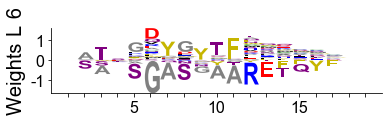

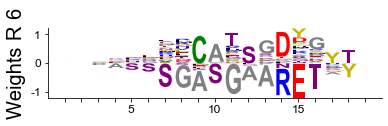

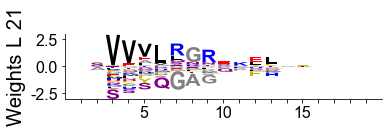

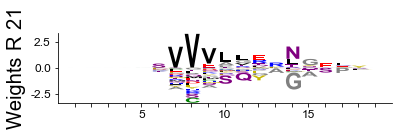

In [47]:
## extract the weights from the left and the right for a RBM model (RBM_post)
(Wzs_fin_L, Wzs_fin_R) = weights_LR(RBM_post,max_L)
s2=16
for h in [5,20]:
    fig = sequence_logo.Sequence_logo(Wzs_fin_L[h], figsize=(5.5,1.8), ylabel = r'Weights L ' + str(h+1), title=' ', ticks_every = 5,ticks_labels_size=s2)
    fig = sequence_logo.Sequence_logo(Wzs_fin_R[h],figsize=(5.5,1.8), ylabel = r'Weights R ' + str(h+1), title=' ', ticks_every = 5,ticks_labels_size=s2-2-2)